# 📘 DiverseVul SVM Classifier

This notebook loads a subset of the DiverseVul dataset and applies a basic SVM model to classify vulnerable vs non-vulnerable code samples. We are using the TF-IDF Vectorization for the purpose of running SVM in this case.

Steps:
1. Load and sample the DiverseVul dataset
2. Convert code text to TF-IDF vectors
3. Train the SVM Model
4. Evaluate the model with metrics and visualizations

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [ ]:

import json

# Loading the JSON file
file_path = "...diversevul_20230702.json"       # TODO: Update this path before running
# Line-by-line JSONL loader
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.head()

,func,target,cwe,project,commit_id,hash,size,message
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1,[],gnutls,7ad6162573ba79a4392c63b453ad0220ca6c5ace,73008646937836648589283922871188272089,157,added an extra check while checking the padding.
1,static char *make_filename_safe(const char *fi...,1,[CWE-264],php-src,055ecbc62878e86287d742c7246c21606cee8183,211824207069112513181516095447837228041,22,Improve check for :memory: pseudo-filename in ...
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1,[],busybox,251fc70e9722f931eec23a34030d05ba5f747b0e,21401706257394042943815500829552774160,232,uncompress: fix buffer underrun by corrupted i...
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,135590882627853658533498335902319684573,66,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,27696392987383562433164405181263025184,18,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."


In [ ]:
# Basic viewing of the data we have in df
print(df.columns)
df.iloc[0]

Index(['func', 'target', 'cwe', 'project', 'commit_id', 'hash', 'size',
       'message'],
      dtype='object')


func         int _gnutls_ciphertext2compressed(gnutls_sessi...
target                                                       1
cwe                                                         []
project                                                 gnutls
commit_id             7ad6162573ba79a4392c63b453ad0220ca6c5ace
hash                    73008646937836648589283922871188272089
size                                                       157
message       added an extra check while checking the padding.
Name: 0, dtype: object

In [ ]:
# Due to GPU contstraints of my PC, running the model on 100k samples. Feel free to adjust the samples based on GPU power available.
# Sample balanced dataset (85K safe, 15K vulnerable)

safe_df = df[df['target'] == 0].sample(85000, random_state=42)
vuln_df = df[df['target'] == 1].sample(15000, random_state=42)
df_100k = pd.concat([safe_df, vuln_df]).sample(frac=1, random_state=42)

texts = df_100k['func'].tolist()
labels = df_100k['target'].tolist()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Performing TF-IDF Vectorization
X = TfidfVectorizer().fit_transform(texts)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)


# Running the SVM model and checking the results. The f-1 score of the vulnerable class is what we are looking at.
clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     17000
           1       0.40      0.64      0.49      3000

    accuracy                           0.80     20000
   macro avg       0.67      0.74      0.69     20000
weighted avg       0.85      0.80      0.82     20000



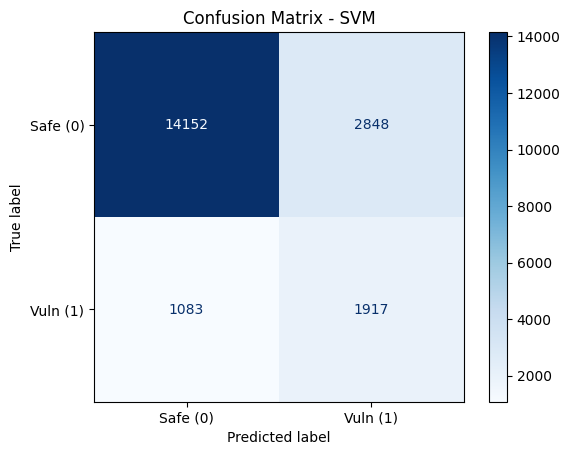

In [ ]:
# Plotting matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe (0)", "Vuln (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()


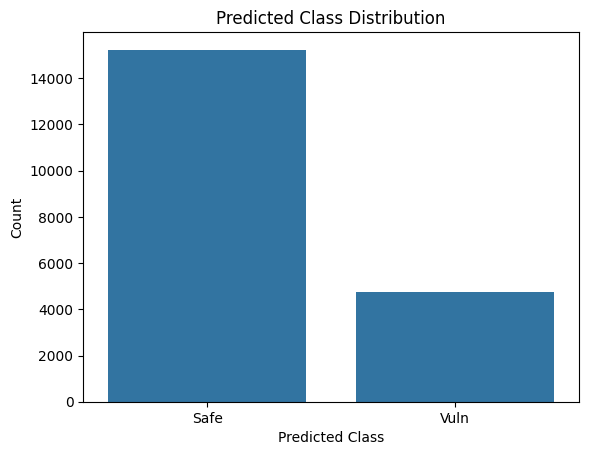

In [ ]:
# Plotting graphs to showcase the results of the SVM run.
import seaborn as sns
import pandas as pd

sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Safe", "Vuln"])
plt.show()

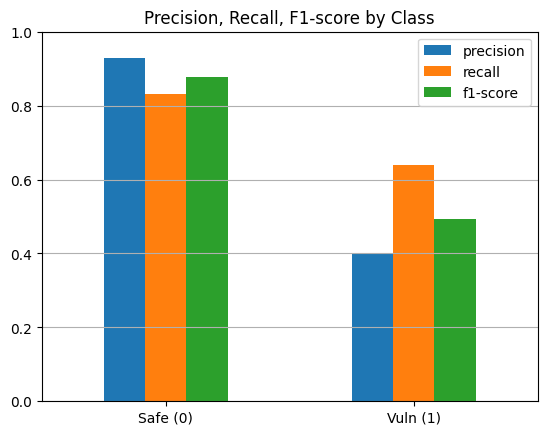

In [ ]:
# Plotting graphs to showcase the results of the SVM run.
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.loc[["0", "1"], ["precision", "recall", "f1-score"]].plot(kind='bar')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks([0, 1], ["Safe (0)", "Vuln (1)"], rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [4]:
# df_sample = df.sample(5000, random_state=42)
# texts = df_sample['func'].tolist()
# labels = df_sample['target'].tolist()

In [5]:
# df_balanced_sample = df.groupby('target', group_keys=False).apply(
#     lambda x: x.sample(25000 if x.name == 0 else 5000, random_state=42)
# )

# # texts = df_balanced_sample['func'].tolist()
# # labels = df_balanced_sample['target'].tolist()

# texts = df['func'].tolist()
# labels = df['target'].tolist()

In [11]:
# from sklearn.metrics import roc_curve, auc

# clf = SVC(kernel='linear', class_weight='balanced', probability=True)
# clf.fit(X_train, y_train)
# y_scores = clf.predict_proba(X_test)[:, 1]

# fpr, tpr, _ = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.title("ROC Curve - SVM")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.show()